In [59]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [60]:
actions = [
    'select', 'close', 'move'
]

data = np.concatenate([
    np.load('dataset/seq_select_1674716574.npy'),
    np.load('dataset/seq_close_1674716574.npy'),
    np.load('dataset/seq_move_1674716574.npy')
], axis=0)

data.shape

(2593, 30, 100)

In [61]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2593, 30, 99)
(2593,)


In [62]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2593, 3)

In [63]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2333, 30, 99) (2333, 3)
(260, 30, 99) (260, 3)


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                41984     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
73/73 [==============================] - ETA: 0s - loss: 8.5047 - acc: 0.7600
Epoch 1: val_acc improved from -inf to 0.87692, saving model to models\model.h5
73/73 [==============================] - 2s 9ms/step - loss: 8.5047 - acc: 0.7600 - val_loss: 2.9503 - val_acc: 0.8769 - lr: 0.0010
Epoch 2/200
73/73 [==============================] - ETA: 0s - loss: 0.8748 - acc: 0.9130
Epoch 2: val_acc improved from 0.87692 to 0.93846, saving model to models\model.h5
73/73 [==============================] - 1s 7ms/step - loss: 0.8748 - acc: 0.9130 - val_loss: 0.3213 - val_acc: 0.9385 - lr: 0.0010
Epoch 3/200
72/73 [============================>.] - ETA: 0s - loss: 0.3812 - acc: 0.9570
Epoch 3: val_acc improved from 0.93846 to 0.98462, saving model to models\model.h5
73/73 [==============================] - 1s 7ms/step - loss: 0.3769 - acc: 0.9571 - val_loss: 0.0465 - val_acc: 0.9846 - lr: 0.0010
Epoch 4/200
72/73 [============================>.] - ETA: 0s - loss: 0.7952 - acc: 0.941

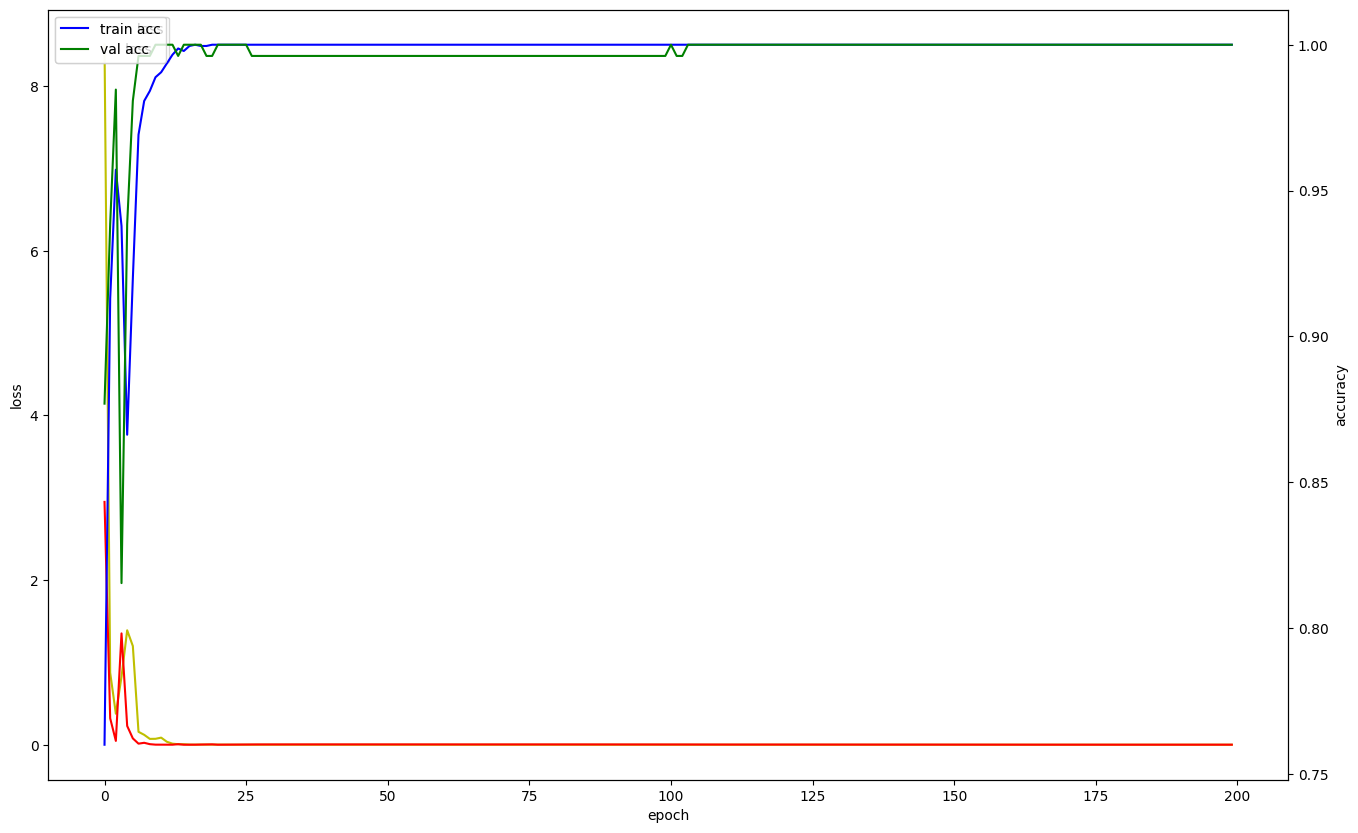

In [66]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [67]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

9/9 [==============================] - 0s 3ms/step


array([[[180,   0],
        [  0,  80]],

       [[158,   0],
        [  0, 102]],

       [[182,   0],
        [  0,  78]]], dtype=int64)